# Split the Data Into Train and Test Set     
1) Split your data into a train and a test set
2) Check some statistics to make sure that there isn't a bias between train/test

## Requirements

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [2]:
# Only on Google Colab
# !pip install pyarrow

## Read Data
Note: Make sure to upload the data files to the working environment.

In [3]:
inflow_df = pd.read_parquet('ucsd-inflows.pqt')
outflow_df = pd.read_parquet('ucsd-outflows.pqt')

print("Inflow Data")
display(inflow_df.head())

print("\nOutflow Data")
display(outflow_df.head())

Inflow Data


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.0200,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.2900,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.0000,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-07-29,EXTERNAL_TRANSFER



Outflow Data


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.6000,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.0000,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.0000,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES


## Consumer and Account ID

In [4]:
# Number of unique consumer_ids and account_ids
unique_consumers = outflow_df['prism_consumer_id'].nunique()
unique_accounts = outflow_df['prism_account_id'].nunique()

print(f"Unique consumer_ids: {unique_consumers}")
print(f"Unique account_ids: {unique_accounts}")

Unique consumer_ids: 2968
Unique account_ids: 4622


In [5]:
# Count occurrences of each consumer_id and account_id
consumer_id_counts = outflow_df['prism_consumer_id'].value_counts()
account_id_counts = outflow_df['prism_account_id'].value_counts()

print(consumer_id_counts.head())
print(account_id_counts.head())

prism_consumer_id
5892    5470
4215    5041
5838    4822
5388    4781
4756    4460
Name: count, dtype: int64
prism_account_id
acc_9475    5470
acc_7798    5041
acc_9421    4822
acc_8971    4781
acc_8339    4460
Name: count, dtype: int64


## Splitting

In [6]:
# Combine inflow and outflow dataframes
combined_df = pd.concat([inflow_df, outflow_df])

# Get unique consumer IDs
consumer_ids = combined_df['prism_consumer_id'].unique()

# Split consumer IDs into train and test
train_ids, test_ids = train_test_split(consumer_ids, test_size=0.2, random_state=100)

# Create train and test sets based on consumer IDs
train_df = combined_df[combined_df['prism_consumer_id'].isin(train_ids)]
test_df = combined_df[combined_df['prism_consumer_id'].isin(test_ids)]

In [7]:
display(train_df.head())
display(test_df.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
91,2,acc_3,DEPOSIT,19.0000,2021-04-08,DEPOSIT
92,2,acc_3,SELF_TRANSFER,250.0000,2021-08-30,SELF_TRANSFER
93,2,acc_3,SELF_TRANSFER,1000.0000,2021-10-06,SELF_TRANSFER
94,2,acc_3,SELF_TRANSFER,300.0000,2021-08-09,SELF_TRANSFER
95,2,acc_3,SELF_TRANSFER,300.0000,2021-11-03,SELF_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.0200,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.2900,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.0000,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-07-29,EXTERNAL_TRANSFER


## Compare Statistics to Check for Bias

In [8]:
def compute_statistics(df, name):
    stats = {
        f"{name}_num_transactions": len(df),
        f"{name}_total_amount": df['amount'].sum(),
        f"{name}_avg_transaction_amount": df['amount'].mean(),
        f"{name}_unique_categories": df['category'].nunique(),
        f"{name}_unique_consumers": df['prism_consumer_id'].nunique()
    }
    return stats

In [9]:
# Compute statistics for train and test sets
train_stats = compute_statistics(train_df, "train")
test_stats = compute_statistics(test_df, "test")

# Compare category distributions
category_train_dist = train_df['category'].value_counts(normalize=True)
category_test_dist = test_df['category'].value_counts(normalize=True)

# Create a DataFrame to compare train and test statistics
comparison_df = pd.DataFrame({
    'Metric': ['Number of Transactions', 'Total Amount', 'Avg Transaction Amount', 'Unique Categories', 'Unique Consumers'],
    'Train Set': [train_stats['train_num_transactions'], train_stats['train_total_amount'], train_stats['train_avg_transaction_amount'],
                  train_stats['train_unique_categories'], train_stats['train_unique_consumers']],
    'Test Set': [test_stats['test_num_transactions'], test_stats['test_total_amount'], test_stats['test_avg_transaction_amount'],
                 test_stats['test_unique_categories'], test_stats['test_unique_consumers']]
})

display(comparison_df)

,Metric,Train Set,Test Set
0,Number of Transactions,2504861.0000,605742.0000
1,Total Amount,598203069.6200,155746499.6800
2,Avg Transaction Amount,238.8169,257.1169
3,Unique Categories,36.0000,36.0000
4,Unique Consumers,2380.0000,595.0000


## Visual Analysis of Bias

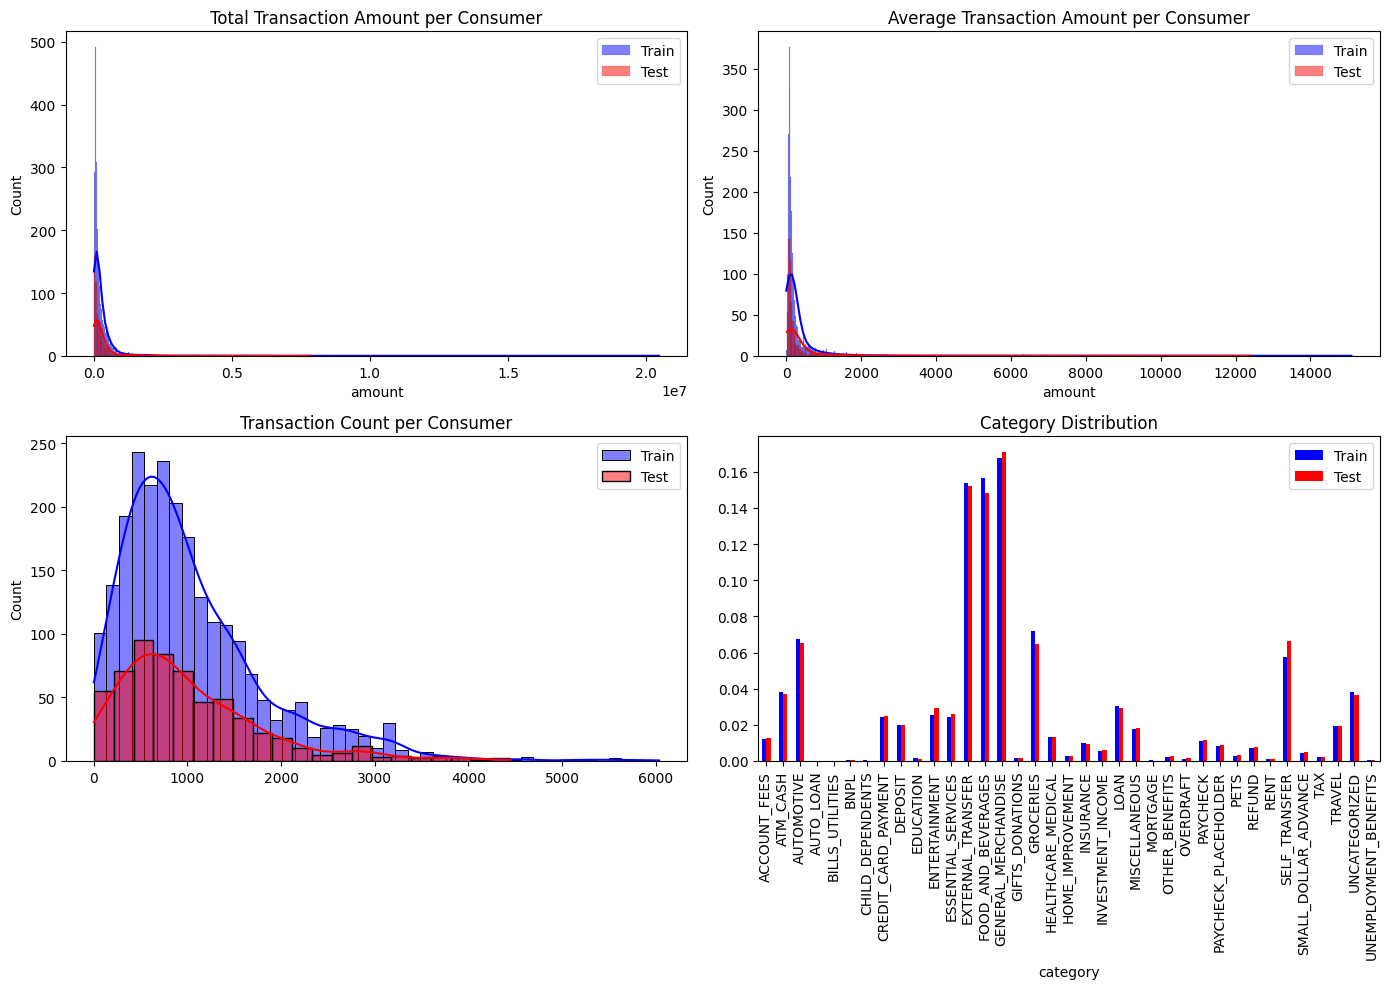

In [10]:
def plot_distribution(train_df, test_df):
    # Total transaction amount per consumer
    train_amount_per_consumer = train_df.groupby('prism_consumer_id')['amount'].sum()
    test_amount_per_consumer = test_df.groupby('prism_consumer_id')['amount'].sum()
    
    # Average transaction amount per consumer
    train_avg_amount_per_consumer = train_df.groupby('prism_consumer_id')['amount'].mean()
    test_avg_amount_per_consumer = test_df.groupby('prism_consumer_id')['amount'].mean()
    
    # Transaction count per consumer
    train_txn_count_per_consumer = train_df.groupby('prism_consumer_id').size()
    test_txn_count_per_consumer = test_df.groupby('prism_consumer_id').size()
    
    # Category distribution
    category_train_dist = train_df['category'].value_counts(normalize=True)
    category_test_dist = test_df['category'].value_counts(normalize=True)

    plt.figure(figsize=(14, 10))

    # Total transaction amounts per consumer
    plt.subplot(2, 2, 1)
    sns.histplot(train_amount_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_amount_per_consumer, kde=True, color='red', label='Test')
    plt.title('Total Transaction Amount per Consumer')
    plt.legend()

    # Average transaction amount per consumer
    plt.subplot(2, 2, 2)
    sns.histplot(train_avg_amount_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_avg_amount_per_consumer, kde=True, color='red', label='Test')
    plt.title('Average Transaction Amount per Consumer')
    plt.legend()

    # Transaction count per consumer
    plt.subplot(2, 2, 3)
    sns.histplot(train_txn_count_per_consumer, kde=True, color='blue', label='Train')
    sns.histplot(test_txn_count_per_consumer, kde=True, color='red', label='Test')
    plt.title('Transaction Count per Consumer')
    plt.legend()

    # Category distribution (bar plot)
    plt.subplot(2, 2, 4)
    category_comparison = pd.DataFrame({
        'train': category_train_dist,
        'test': category_test_dist
    }).fillna(0)
    category_comparison.plot(kind='bar', ax=plt.gca(), color=['blue', 'red'])
    plt.title('Category Distribution')
    plt.legend(['Train', 'Test'])

    plt.tight_layout()
    plt.show()

plot_distribution(train_df, test_df)

## Chi-Square Test for Category Distribution

In [11]:
# Calculate category proportions in train and test sets
category_train_proportions = train_df['category'].value_counts(normalize=True)
category_test_proportions = test_df['category'].value_counts(normalize=True)

# Create a contingency table using proportions
category_comparison_df = pd.DataFrame({
    'train_proportion': category_train_proportions,
    'test_proportion': category_test_proportions
}).fillna(0)  # Filling missing categories with 0 proportions

display(category_comparison_df)

,train_proportion,test_proportion
category,,
ACCOUNT_FEES,0.0120,0.0125
ATM_CASH,0.0380,0.0373
AUTOMOTIVE,0.0675,0.0651
AUTO_LOAN,0.0000,0.0000
BILLS_UTILITIES,0.0000,0.0000
BNPL,0.0004,0.0007
CHILD_DEPENDENTS,0.0003,0.0001
CREDIT_CARD_PAYMENT,0.0241,0.0248
DEPOSIT,0.0197,0.0197


In [12]:
def run_chi_square_test(df, p):
    chi2, p_value, dof, expected = chi2_contingency(df)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    
    if p_value < p:
        print("There is a statistically significant difference between the category distributions of Train and Test sets.")
    else:
        print("There is no statistically significant difference between the category distributions of Train and Test sets.")

In [13]:
run_chi_square_test(category_comparison_df, 0.05)

Chi-Square Statistic: 0.002297768507344306
P-value: 1.0
Degrees of Freedom: 36
There is no statistically significant difference between the category distributions of Train and Test sets.


In [14]:
# Create a new copy of the DataFrame
new_category_comparison_df = category_comparison_df.copy()

# Intentionally modify a value to check if the test is implemented correctly
category_to_modify = 'SELF_TRANSFER'
if category_to_modify in new_category_comparison_df.index:
    new_category_comparison_df.loc[category_to_modify, 'test_proportion'] += 100
else:
    print(f"Category '{category_to_modify}' not found in the data.")

# Run the chi-square test on the new copy
run_chi_square_test(new_category_comparison_df, 0.05)


Chi-Square Statistic: 47.832128787623645
P-value: 0.08974892088787191
Degrees of Freedom: 36
There is no statistically significant difference between the category distributions of Train and Test sets.
